# Import Libraries and Data

In [193]:
import pandas as pd
import matplotlib.pyplot as plt
import re

import numpy as np
from functools import reduce
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn import linear_model
import torch
import torch.nn as nn
from tqdm import tqdm
import warnings

In [75]:
DATA_PATH = '../data'

In [200]:
cons = pd.read_parquet(f'{DATA_PATH}/raw/q2_consDF_final.pqt')
acct = pd.read_parquet(f'{DATA_PATH}/raw/q2_acctDF_final.pqt')
inflows = pd.read_parquet(f'{DATA_PATH}/raw/q2_inflows_final.pqt')
outflows = pd.read_parquet(f'{DATA_PATH}/raw/q2_outflows_final.pqt')

# Create Features

In [201]:
features = []

### Max Balance at time of evaluation
The maximum balance a consumer has in any of their accounts at the time of evaluation

In [202]:
balance_var = acct[['prism_consumer_id','balance','balance_date']].groupby('prism_consumer_id').agg({
    'balance':['min', 'max', 'std'],
    'balance_date':['max']
}).reset_index()
balance_var.fillna(0.0, inplace=True)

balance_var.columns = balance_var.columns.to_flat_index().map(lambda x: x[1] + x[0])
features.append(balance_var)
balance_var.head()

,prism_consumer_id,minbalance,maxbalance,stdbalance,maxbalance_date
0,0,6182.60,9907.23,2633.711130,2023-04-13
1,2,8079.43,17426.83,6609.609926,2022-02-15
2,4,0.00,4871.39,2644.903088,2021-08-13
3,7,517.95,7071.18,3766.231217,2021-08-08
4,9,13348.76,13348.76,0.000000,2023-04-19


### Disposable Income
How much disposable income does a consumer have available after looking at all purchases and income sources in the dataset

In [203]:
cons_eval_dates = cons.sort_values('evaluation_date')[['prism_consumer_id','evaluation_date']]
outflow_merged = pd.merge(outflows, cons_eval_dates, on="prism_consumer_id", how="left")
inflow_merged = pd.merge(inflows, cons_eval_dates, on="prism_consumer_id", how="left")
outflow_merged['amount'] = outflow_merged['amount'] * -1
total_cashflow = pd.concat([inflow_merged, outflow_merged])

total_cashflow = total_cashflow[total_cashflow['posted_date'] <= total_cashflow['evaluation_date']]

total_balance = (
    total_cashflow[[
        'prism_consumer_id',
        'amount',
        'posted_date',
    ]]
    .groupby('prism_consumer_id')
    .agg({
        'amount':['sum'],
        'posted_date':['min','max']
    })
)

total_balance['date_range'] = pd.to_timedelta(total_balance['posted_date','max'] - total_balance['posted_date','min']).dt.days / 365
total_balance = pd.DataFrame({
    'total_balance': total_balance['amount','sum'] / total_balance['date_range'], 
    'total_balance_date': total_balance['posted_date', 'max']
}).reset_index()

features.append(total_balance)
total_balance.head()

,prism_consumer_id,total_balance,total_balance_date
0,0,15154.285773,2023-04-12
1,2,1546.065942,2022-02-14
2,4,3377.081389,2021-08-12
3,7,7311.445429,2021-08-06
4,9,5873.815289,2023-04-18


### Monthly Balance Statistics
Features that look at average monthly activity:
 - Average Monthly Spending
 - Average number of purchases made per month

In [204]:
outflow_valid = outflow_merged[outflow_merged['posted_date'] <= outflow_merged['evaluation_date']]
outflow_counts = outflow_valid.groupby('prism_consumer_id').agg({
    'amount':['count','sum'],
    'posted_date':['min','max'],
}).reset_index()

outflow_counts['date_range'] = pd.to_timedelta(outflow_counts['posted_date','max'] - outflow_counts['posted_date','min']).dt.days / 365 * 12

outflow_counts = pd.DataFrame({
    'prism_consumer_id': outflow_counts['prism_consumer_id'],
    'avg_monthly_spending': -1 * outflow_counts['amount','sum'] / outflow_counts['date_range'],
    'num_monthly_purchase': outflow_counts['amount','count'] / outflow_counts['date_range'],
    # 'monthly_purchase_date': outflow_counts['posted_date','max'],
})

outflow_counts.replace([np.inf, -np.inf], 0.0, inplace=True)
features.append(outflow_counts)
outflow_counts.head()

,prism_consumer_id,avg_monthly_spending,num_monthly_purchase
0,0,7703.614883,80.915055
1,2,9354.337258,98.743961
2,4,30563.426238,33.035880
3,7,23188.278116,138.265235
4,9,11186.144777,79.267677


### Savings Feature
A count of how many times someone has pulled from savings account


In [205]:
transfer_from_savings = inflows[inflows['category_description']=='SELF_TRANSFER']
transfer_from_savings = transfer_from_savings[transfer_from_savings['memo_clean'].str.contains('Savings')]
count_tfs = transfer_from_savings.groupby('prism_consumer_id').count().reset_index()
inflow_ids = pd.merge(inflows[['prism_consumer_id']], count_tfs, on='prism_consumer_id', how='left')
inflow_ids = inflow_ids.fillna(0).drop_duplicates(subset=['prism_consumer_id']).reset_index()[['prism_consumer_id', 'memo_clean']]

features.append(inflow_ids)
inflow_ids

,prism_consumer_id,memo_clean
0,0,0.0
1,2,0.0
2,4,0.0
3,7,0.0
4,9,0.0
...,...,...
2973,3991,63.0
2974,3992,0.0
2975,3993,22.0
2976,3996,241.0


### Unsufficient Funds
A boolean output for whether a consumer has an account that is negative or near 0.

In [206]:
acct['unsufficient_balance'] = acct['balance'].apply(lambda x: x <= 1)
unsufficient_accts = acct.groupby('prism_consumer_id')['unsufficient_balance'].count().reset_index()[['prism_consumer_id', 'unsufficient_balance']]
unsufficient_accts.head()


,prism_consumer_id,unsufficient_balance
0,0,2
1,2,2
2,4,3
3,7,3
4,9,1


### Amount of Accounts Per User
A number that represents the total number of accounts each consumer has.

In [183]:
acct = acct.rename(columns = {'prism_consumer_id':'grouping_prism_consumer_id'})
account_count = acct.groupby('grouping_prism_consumer_id')[['grouping_prism_consumer_id']].count()
account_count = account_count.rename(columns = {'grouping_prism_consumer_id':'account_count'}).reset_index()
account_count = account_count.rename(columns = {'grouping_prism_consumer_id': 'prism_consumer_id'})

features.append(account_count)

### Positive Remaining Ratio
Determines the amount of months where cashflow is positive out of all months in the dataset for each consumer

In [185]:
def get_PRR(total_cashflow):
    # Get month and year of inflow and outflow
    total_cashflow = total_cashflow.copy()
    total_cashflow['month'] = pd.to_datetime(total_cashflow['posted_date']).dt.month
    total_cashflow['year'] = pd.to_datetime(total_cashflow['posted_date']).dt.year
    # Group transactions by month and calculate remaining balance on each month for each client
    total_cashflow = total_cashflow.groupby(['prism_consumer_id', 'year', 'month'])['amount'].sum().reset_index()
    # Determine if the remaining amount is positive for each month
    total_cashflow['PRR'] = (total_cashflow['amount'] > 0).astype(int)
    # Calculate the ratio of months with positive remaining amounts
    total_cashflow = total_cashflow.groupby('prism_consumer_id')['PRR'].mean().reset_index()
    return total_cashflow

In [186]:
PRR = get_PRR(total_cashflow)
features.append(PRR)
PRR.head()

,prism_consumer_id,PRR
0,0,0.538462
1,2,0.333333
2,4,0.461538
3,7,0.384615
4,9,0.538462


### Credit Ratio
Determines the maximum number of consecutive months in which a consumer pays of a loan

In [187]:
def get_CR(outflows):
    # Get month range
    outflow_transactions = outflows.copy()
    outflow_transactions['month'] = pd.to_datetime(outflow_transactions['posted_date']).dt.month
    outflow_transactions['year'] = pd.to_datetime(outflow_transactions['posted_date']).dt.year
    outflow_transactions['date_id'] = 12 * (outflow_transactions['year'] - min(outflow_transactions['year'])) + outflow_transactions['month']
    # Get number of transactions for each category for each consumer
    cat_groups = outflow_transactions.groupby(['prism_consumer_id', 'date_id', 'category_description']).size().reset_index(name='count')
    # Find number of months where consumer spent money on credit card payments or loans
    cat_counts = cat_groups.groupby(['prism_consumer_id','category_description']).agg({'count':'count', 'date_id':['min', 'max']}).reset_index()
    credit_counts = cat_counts[np.isin(cat_counts['category_description'], ['LOAN', 'CREDIT_CARD_PAYMENT'])].copy()
    # Get maximum credit ratio
    credit_counts['CR'] = credit_counts['count','count'] / (credit_counts['date_id','max'] - credit_counts['date_id','min'] + 1)
    return credit_counts.groupby('prism_consumer_id')['CR'].max().reset_index()

In [188]:
CR = get_CR(outflows)
features.append(CR)
CR.head()

,prism_consumer_id,CR
0,0,1.0
1,2,1.0
2,4,1.0
3,7,1.0
4,9,1.0


### Merge all features into feature matrix

In [189]:
feature_df = reduce(
    lambda left,right: pd.merge(left,right, on='prism_consumer_id', how='outer'), 
    features
)

feature_dates = re.findall(r"\w+_date", str(list(feature_df.columns)))
feature_df['feature_date'] = feature_df[feature_dates].max(axis=1)
feature_df.drop(feature_dates, axis=1, inplace=True)
feature_df.fillna(0.0, inplace=True)
feature_df

,prism_consumer_id,minbalance,maxbalance,stdbalance,total_balance,avg_monthly_spending,num_monthly_purchase,memo_clean,account_count,PRR,CR,feature_date
0,0,6182.60,9907.23,2633.711130,15154.285773,7703.614883,80.915055,0.0,2,0.538462,1.0,2023-04-13
1,2,8079.43,17426.83,6609.609926,1546.065942,9354.337258,98.743961,0.0,2,0.333333,1.0,2022-02-15
2,4,0.00,4871.39,2644.903088,3377.081389,30563.426238,33.035880,0.0,3,0.461538,1.0,2021-08-13
3,7,517.95,7071.18,3766.231217,7311.445429,23188.278116,138.265235,0.0,3,0.384615,1.0,2021-08-08
4,9,13348.76,13348.76,0.000000,5873.815289,11186.144777,79.267677,0.0,1,0.538462,1.0,2023-04-19
...,...,...,...,...,...,...,...,...,...,...,...,...
2973,5941,2058.81,2058.81,0.000000,-1816.084426,4052.617937,84.468579,0.0,1,0.363636,1.0,2023-01-06
2974,5943,2431.44,2431.44,0.000000,4121.415493,5769.212382,25.538522,0.0,1,0.625000,1.0,2023-02-03
2975,5944,45.74,45.74,0.000000,-765.389130,1987.821739,88.605072,0.0,1,0.500000,1.0,2023-02-01
2976,5945,59.88,59.88,0.000000,-1557.370000,3474.895833,103.541667,0.0,1,0.440000,1.0,2023-02-02


## Final Feature Matrix

In [190]:
sorted_cons = cons.sort_values('evaluation_date')

dropped_cols = ['prism_consumer_id', 'evaluation_date', 'feature_date', 'APPROVED']
feature_matrix = pd.merge(sorted_cons, feature_df, on='prism_consumer_id', how='left')

# Make sure no invalid training data is pulled
assert np.mean(feature_matrix['evaluation_date'] < feature_matrix['feature_date']) == 0, "Features pulled from dates after evaluation_date"
feature_matrix.drop(dropped_cols, axis=1, inplace=True)

In [191]:
feature_matrix.iloc[:,0].head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: FPF_TARGET, dtype: float64

In [192]:
# Train Test Split
TEST_SIZE = 0.2
X = feature_matrix.iloc[:,1:].to_numpy()
y = feature_matrix.iloc[:,0].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size = TEST_SIZE, 
    random_state=42
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, 
    y_train, 
    test_size = TEST_SIZE, 
    random_state=42
)

# Prototype Model to Predict Default Risk

### Training

In [194]:
model = linear_model.LogisticRegression()

In [195]:
model.fit(X_train, y_train)

LogisticRegression()

In [196]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

### Evaluate Model

In [197]:
def get_metrics(pred, actual, display=True):
    cm = confusion_matrix(actual, pred)
    tn, fp, fn, tp = cm.ravel()

    TPR = tp / (tp + fn)
    FPR = tn / (tn + fp)
    if (display):
        print(f"Accuracy: {np.mean(pred == actual):.4f}")
        print(f"tn:  {tn},  fp:  {fp},  fn:  {fn}, tp:  {tp}")
        print(f"Precision:\t\t\t{tp / (tp + fp):.5f}")
        print(f"Recall:\t\t\t\t{tp / (tp + fn):.5f}")
        print(f"TPR:\t\t\t\t{TPR:.5f}")
        print(f"FPR:\t\t\t\t{FPR:.5f}")
        print(f"Positive likelihood ratio:\t{TPR/FPR:.5f}")
        print(f"Negative likelihood ratio:\t{FPR/TPR:.5f}")
        return
    return [tn, fp, fn, tp, TPR, FPR, TPR/FPR, FPR/TPR]

In [198]:
print("Training:")
get_metrics(train_pred, y_train)
print("===========================")
print("Test:")
get_metrics(test_pred, y_test)

Training:
Accuracy: 0.8152
tn:  1523,  fp:  21,  fn:  331, tp:  30
Precision:			0.58824
Recall:				0.08310
TPR:				0.08310
FPR:				0.98640
Positive likelihood ratio:	0.08425
Negative likelihood ratio:	11.86967
Test:
Accuracy: 0.8473
tn:  495,  fp:  3,  fn:  88, tp:  10
Precision:			0.76923
Recall:				0.10204
TPR:				0.10204
FPR:				0.99398
Positive likelihood ratio:	0.10266
Negative likelihood ratio:	9.74096


# Prototype 2: Basic Sequential NN

### Define Model

In [22]:
# Define the model
model = nn.Sequential(
    nn.Linear(X.shape[1], 12),
    nn.ReLU(),
    nn.Linear(12, 24),
    nn.ReLU(),
    nn.Linear(24, 24),
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.ReLU(),
    nn.Linear(12, 6),
    nn.ReLU(),
    nn.Linear(6, 1)
)

In [23]:
# loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

### Training

In [24]:
# training parameters
n_epochs = 300   # number of epochs to run
batch_size = 5  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

In [25]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train * 2 - 1, dtype=torch.float32).reshape(-1, 1)
X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid * 2 - 1, dtype=torch.float32).reshape(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test * 2 - 1, dtype=torch.float32).reshape(-1, 1)

In [26]:
train_history = []
valid_history = []
 
# training loop
bar = tqdm(range(n_epochs))
for epoch in bar:
    model.train()
    bar.set_description(f"Epoch {epoch+1}")
    for start in batch_start:
        # take a batch
        X_batch = X_train_tensor[start:start+batch_size]
        y_batch = y_train_tensor[start:start+batch_size]
        # forward pass
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred_train = model(X_train_tensor)
    y_pred_valid = model(X_valid_tensor)
    train_loss = float(loss_fn(y_pred_train, y_train_tensor))
    valid_loss = float(loss_fn(y_pred_valid, y_valid_tensor))
    
    bar.set_postfix(Train_MSE = float(train_loss), Valid_MSE = float(valid_loss))
    train_history.append(train_loss)
    valid_history.append(valid_loss)

Epoch 1:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 300: 100%|██████████| 300/300 [02:58<00:00,  1.68it/s, Train_MSE=0.499, Valid_MSE=0.608]


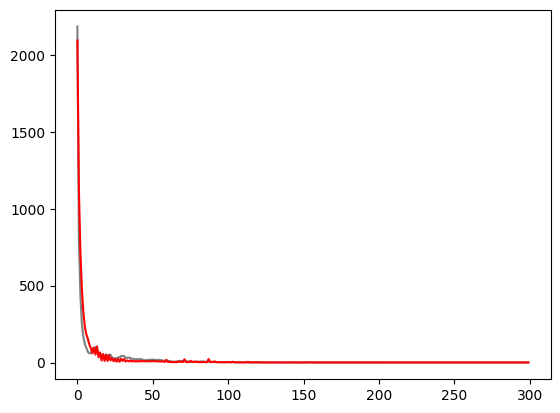

In [27]:
plt.plot(train_history, 'gray')
plt.plot(valid_history, 'r')

### Evaluate Model

In [79]:
# train_pred = model.predict(X_train)
def standardize_output(arr):
    return ((arr - min(arr)) / (max(arr) - min(arr)))

def find_best_prob(pred_prob, actual):
    best_prob = 0
    best_ratio = np.inf
    prob_interval = 0.05
    with np.errstate(divide='ignore'):
        for i in np.arange(0, 1.0, prob_interval):
            pred = pred_prob > i
            metrics = get_metrics(pred, actual, display=False)
            
            PLR = metrics[6]
            NLR = metrics[7]
            ratio = (PLR + NLR)/2

            print(f"{i:.2f}\t{ratio:0.3f}\t{((metrics[0] + metrics[3]) / np.sum(metrics[:4]) * 100):.2f}\t{metrics[:4]}")

            if (ratio < best_ratio):
                best_ratio = ratio
                best_prob = i
    return best_prob

In [80]:
valid_pred_raw = model(X_valid_tensor).detach().numpy()[:,0]
valid_pred_prob = standardize_output(valid_pred_raw)
best_prob = find_best_prob(valid_pred_prob, y_valid)
valid_pred = valid_pred_prob > best_prob
print(f"Best Predicted Probability: {best_prob}")

test_pred_raw = model(X_test_tensor).detach().numpy()[:,0]
test_pred_prob = standardize_output(test_pred_raw)
test_pred = test_pred_prob > best_prob

0.00	187.501	21.59	[1, 374, 0, 102]
0.05	187.501	21.59	[1, 374, 0, 102]
0.10	187.501	21.59	[1, 374, 0, 102]
0.15	62.504	22.01	[3, 372, 0, 102]
0.20	37.507	22.43	[5, 370, 0, 102]
0.25	31.258	22.64	[6, 369, 0, 102]
0.30	9.402	25.58	[20, 355, 0, 102]
0.35	2.102	40.88	[94, 281, 1, 101]
0.40	1.052	63.73	[221, 154, 19, 83]
0.45	1.040	75.05	[297, 78, 41, 61]
0.50	1.587	78.62	[342, 33, 69, 33]
0.55	2.389	78.20	[352, 23, 81, 21]
0.60	2.797	78.83	[358, 17, 84, 18]
0.65	3.597	79.04	[363, 12, 88, 14]
0.70	6.279	78.62	[367, 8, 94, 8]
0.75	12.498	77.78	[367, 8, 98, 4]
0.80	inf	77.36	[369, 6, 102, 0]
0.85	inf	77.99	[372, 3, 102, 0]
0.90	inf	78.20	[373, 2, 102, 0]
0.95	inf	78.20	[373, 2, 102, 0]
Best Predicted Probability: 0.45


In [46]:
print("Validation:")
get_metrics(valid_pred, y_valid)
print("===========================")
print("Testing:")
get_metrics(test_pred, y_test)

Validation:
Accuracy: 0.7505
tn:  297,  fp:  78,  fn:  41, tp:  61
Precision:			0.43885
Recall:				0.59804
TPR:				0.59804
FPR:				0.79200
Positive likelihood ratio:	0.75510
Negative likelihood ratio:	1.32433
Testing:
Accuracy: 0.8138
tn:  440,  fp:  58,  fn:  53, tp:  45
Precision:			0.43689
Recall:				0.45918
TPR:				0.45918
FPR:				0.88353
Positive likelihood ratio:	0.51971
Negative likelihood ratio:	1.92414
